In [8]:
import time

import utils
#import models
import pickle

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, Normalizer, RobustScaler, StandardScaler

import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdReducedGraphs import GenerateErGFingerprintForReducedGraph
from rdkit.Chem import AllChem, rdReducedGraphs
from rdkit.Chem import DataStructs
from rdkit import rdBase
import numpy as np
from rdkit.Chem import RDConfig

pca = PCA(.8)
colors = ['#f25c9d', '#F2A25C', '#5B98A6', '#8BB63C']
path = 'f:/_phd/Docking_score/VDR/Data/'

In [32]:
df1 = pd.read_csv(path + "VDR_VDRML_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")
df2 = pd.read_csv(path + "VDR_actives_decoys_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")
df = pd.concat([df1, df2])
names = df.columns[2:].to_list()
names = ['id', 'smi', 'label'] + names

df = df.rename(columns={'smiles': 'smi'})

a = df.id.str[:3]
df['label'] =  np.where(a == 'CHE', 1, np.where(a == 'VDR', 2, 3))

names_ds = [n for n in names if 'rank' not in n]


df = df[names_ds]
names_ds = names_ds[5:]

df.shape

(17540, 15)

In [31]:
df

,id,smi,label,ECR_1DB1,ECR_3KPZ,docking_score_CHEMPLP_1DB1,docking_score_CHEMPLP_3KPZ,docking_score_london_1DB1,docking_score_london_3KPZ,docking_score_ASE_1DB1,docking_score_ASE_3KPZ,docking_score_AHB_1DB1,docking_score_AHB_3KPZ,docking_score_AdG_1DB1,docking_score_AdG_3KPZ,x
28,VDRML10436,O(Cc1ccccc1)c1ccc(cc1C)C(CC)(CC)c1cc(C)c(OC(CC...,1,5.502322e-03,1.876212e-51,-125.9040,-17.8102,-16.937466,-14.419932,-35.536564,-33.724304,-113.827190,-119.902050,-7.806695,-6.708219,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
29,VDRML3285,FC(F)(F)C(O)(C=CC=C(CC)c1cc(ccc1)CNc1cc(CO)c(O...,1,4.978707e-03,4.204651e-15,-127.0200,-16.3726,-16.927639,-14.640705,-31.084734,-30.532642,-109.029500,-119.170340,-10.194674,-10.326018,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31,VDRML1550,O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CC)c1ccc(NC(=...,1,1.632186e-02,2.362039e-03,-130.2690,-17.2059,-16.865726,-16.724377,-34.521851,-33.285480,-134.694110,-141.994400,-7.056280,-7.936399,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32,VDRML12442,FCc1cc(ccc1OCC(O)C(C)(C)C)C(CC)(CC)c1cc(C)c(OC...,1,1.111567e-02,4.441440e-36,-142.3680,-17.7340,-16.864937,-14.720942,-36.679596,-34.978161,-112.553210,-124.514600,-8.171332,-5.010343,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
34,VDRML12495,O(C(CCO)CO)c1ccc(cc1C)COc1cc(ccc1)-c1ccc(cc1C)...,1,3.019738e-03,6.244560e-168,-121.7670,-15.9780,-16.837725,-13.079225,-33.456936,-32.451694,-94.694252,-110.008760,-1.227825,-0.504915,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,C95887349,ClC(Cl)(Cl)C=1N=C2[C@H](N=1)C=CC=C2,3,2.062842e-49,1.253389e-11,-65.5789,-19.3694,-7.709933,-8.189774,-14.323812,-14.675950,-67.376793,-78.411888,-4.369405,-4.586325,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2023,C39961264,Brc1ccc(nc1F)N1CCCC1,3,3.314257e-39,5.502322e-03,-73.0001,-20.0000,-7.555915,-8.380680,-18.885298,-18.574732,-68.328430,-74.594933,-5.340286,-5.472522,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2025,C86815921,s1cc(C=2OC(=S)NN=2)c(c1)C,3,1.693284e-50,7.408182e-02,-64.7367,-20.0000,-7.431933,-7.596510,-14.249882,-14.344195,-68.330101,-74.171303,-4.242002,-4.903995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2026,C19413968,BrC=1C=Cc2nc(cn2C=1)CCl,3,3.340060e-42,1.542811e-14,-71.4459,-19.2998,-7.382145,-8.332200,-14.833597,-15.800166,-62.985973,-76.272949,-5.128568,-4.763969,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# outliers

In [6]:
from scipy import stats
for i in range(len(names_ds)):
    z = np.abs(stats.zscore(df[names_ds[i]]))
    df = df[(z < 3.0)] 

df.shape

(16285, 15)

# Normalization and sampling

In [36]:
from sklearn.preprocessing import MinMaxScaler

x = utils.morgan(df)
df['x']= x
df_train = df.sample(n=15000)

scaler = MinMaxScaler()
df_train[names_ds] = scaler.fit_transform(df_train[names_ds])
####################################
x_sample = df_train['x'].tolist() 

pca.fit(x_sample)
morg_pca = pca.transform(x_sample) 

#svd = TruncatedSVD(600) # more than 90 % of variance covered by 600 components
#morg_svd = svd.fit_transform(x_sample) 

In [10]:
mols = [Chem.MolFromSmiles(mol) for mol in list(df_train['smi'])]
ergfps = [rdReducedGraphs.GetErGFingerprint( mol ) for mol in mols]

In [11]:
pca.fit(ergfps)
ergfps_pca = pca.transform(ergfps)

svd = TruncatedSVD(150)
ergfps_svd = svd.fit_transform(ergfps) 



# modelling

In [12]:
import skopt
from numpy import mean
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn import decomposition
import argparse
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb
from timeit import default_timer as timer

Using TensorFlow backend.
C:\Users\kamcl\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kamcl\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kamcl\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kamcl\Miniconda3\lib\site-packages\tensorflow\python\framework\dtype

In [198]:
h_layers = [(1115, 573, 1075), (1194,405,976,906), 
            (1044,895,132,1134), (290,323,32,345),
            (527,692,311,154,528), (799,701,929,11,471),
            (79,405,425,704,1076), (909,960,370),
            (767,487,169,1060), (906,388,1190,937,1067)]

# sample part of the data

# input vectors

results:  -0.002587837736775204
results:  -0.009904872608914764
results:  -0.006639016370724451
results:  -0.007617568717226089
results:  -0.002442000945059939
results:  -0.002372428877668748
results:  -0.008380271414617444
results:  -0.007653545389175756
results:  -0.006757571777033532
results:  -0.004743790468605566


In [ ]:
#transform the distribution

In [24]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.stats import norm


scaler = MinMaxScaler()
plt.style.use('seaborn-white')
df_train_transformed = pd.DataFrame.copy(df_train)
df_train_transformed_2 = pd.DataFrame.copy(df_train)


# transform the data
for i, name in enumerate(names_ds):
    #if i == 0 or i == 1 or i == 4 or i == 5:
     #   df_train_transformed[name] = np.abs(df_train[name] - np.mean(df_train[name] ))
 

    df_train_transformed[name] = df_train_transformed[name] + 0.00001
    #df_train_transformed[name] = np.log1p(df_train_transformed[name])
    df_train_transformed[name], _ = boxcox(df_train_transformed[name])
    
    #if i == 8 or i == 9:
       # df_train_transformed[name] = df_train_transformed[name]
        

# show histograms before and after
#df_train_transformed_2 = pd.DataFrame.copy(df_train_transformed)
#df_train_transformed[names_ds] = scaler.fit_transform(df_train_transformed[names_ds])
#df_train_transformed_2[names_ds[-2]] = df_train_transformed_2[names_ds[-2]] - 0.3
#df_train_transformed_2[names_ds[-1]] = df_train_transformed_2[names_ds[-1]] - 0.3

SyntaxError: unexpected EOF while parsing (<ipython-input-24-f0f20516bee1>, line 30)

In [14]:
# plot transformed

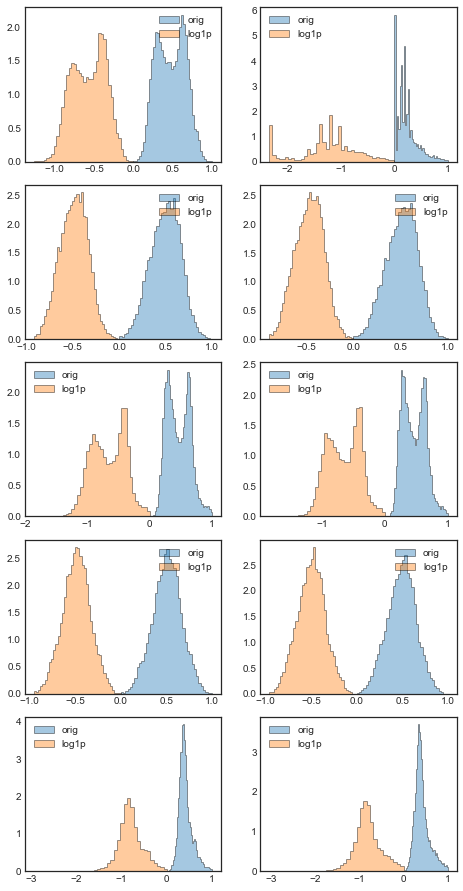

In [15]:
fig = plt.figure(figsize=(6,12)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.2) 

for i, name in enumerate(names_ds):
    ax = fig.add_subplot(5, 2, i+1)
    kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=40, ec="k")
    
    plt.hist(df_train[name], **kwargs)
    plt.hist(df_train_transformed[name], **kwargs)
    #plt.hist(df_train_transformed_2[name], **kwargs)
    #plt.plot(bins, 1/(0.1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - 0.5)**2 / (2 * 0.1**2)))
    plt.legend(labels=['orig', 'log1p']) #'boxcox',

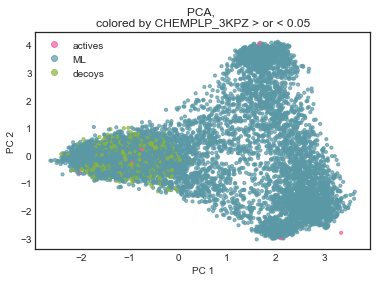

In [39]:
# cutting of the weird portion of the data
import matplotlib
#df_train_transformed_CHEMPLP_3KPZ = 

#df_train_transformed['ds_CHEMPLP_3KPZ_cutted'] = df_train_transformed[names_ds[1]] > 0.05
df_train_transformed['ds_CHEMPLP_3KPZ'] = df_train_transformed[names_ds[1]] > 0.05

plt.title('PCA, \ncolored by CHEMPLP_3KPZ > or < 0.05')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
scatter = plt.scatter(morg_pca[:, 0], morg_pca[:, 1], 
                      c=df_train_transformed['label'], cmap=matplotlib.colors.ListedColormap(colors),
                      s=10, alpha=0.7) #, cmap='bwr'
handles, labels = scatter.legend_elements()
#labels = ['> 0.05', '< 0.05']
labels = ['actives', 'ML', 'decoys']
plt.legend(handles, labels, title='')

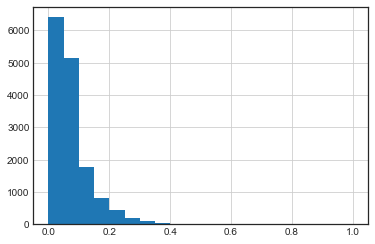

In [37]:
df_train_transformed = pd.DataFrame.copy(df_train)
df_train_transformed[names_ds[1]].hist(bins=20)

In [26]:
names_ds[1]

'docking_score_CHEMPLP_3KPZ'

In [17]:
df_inversed = pd.DataFrame.copy(df_train)
df_inversed[names_ds] = scaler.inverse_transform(df_train[names_ds])
df_inversed[names_ds[1]].hist(bins=40)
plt.title(names_ds[1])

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [11]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdReducedGraphs import GenerateErGFingerprintForReducedGraph
from rdkit.Chem import AllChem, rdReducedGraphs
from rdkit.Chem import DataStructs
from rdkit import rdBase
import numpy as np
from rdkit.Chem import RDConfig

mols = [Chem.MolFromSmiles(mol) for mol in list(df_train['smi'])]
ergfps = [rdReducedGraphs.GetErGFingerprint( mol ) for mol in mols]


In [14]:
#x2 = GenerateErGFingerprintForReducedGraph(mols[0])
pca = PCA(0.9)
pca.fit(ergfps)
ergfps_pca = pca.transform(ergfps)
x_sample = df_train['x'].tolist() 
pca.fit(x_sample)
morg_pca = pca.transform(x_sample) 

ergfps_pca.shape, morg_pca.shape

((15000, 45), (15000, 527))

In [15]:
concat_fps = np.concatenate((ergfps_pca, morg_pca), 1)

In [32]:
#-0.0074598973407036095
#-0.03528186286356892

-0.021039678852989872

In [34]:
#-0.019838703450220863
#-0.01901428399421386
#-0.018759226639810576

-0.018759226639810576

In [25]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, Y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(trainX, trainY)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)
    
def mse_cv(model):
    mse = (-cross_val_score(model, testX, testY, scoring="neg_mean_squared_error", cv = 5))
    
    return(mse)

In [199]:
import xgboost as xgb
import lightgbm as lgb
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
RF = RandomForestRegressor(max_depth=15, random_state=1)
ML =  MLPRegressor(random_state=1, 
                            solver='adam',
                            activation='relu',
                            hidden_layer_sizes=(600, 400, 200, 50))
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [200]:
i = 1
name = names_ds[i]
concat_ergfps_morg_pca = np.concatenate((ergfps, morg_pca), 1)
x = np.array(concat_ergfps_morg_pca)
y = np.array(df_train[name], dtype=np.float32).ravel()
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.33, random_state=1)


#averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

#score = mse_cv(averaged_models)
#print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [201]:
stacked_averaged_models_2 = StackingAveragedModels(base_models = (ML, KRR, RF), meta_model=lasso)
stacked_averaged_models_2.fit(trainX, trainY)
stacked_train_pred = stacked_averaged_models_2.predict(testX)

0.0027198956092844683

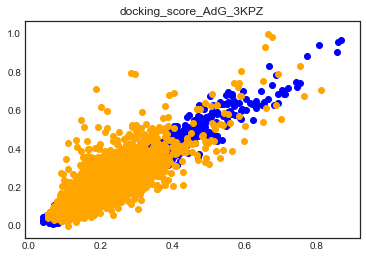

In [204]:
#model = ENet
#model.fit(trainX, trainY)
model = model

a = model.predict(trainX)
b = np.array(trainY, dtype=np.float32)
plt.scatter(a, b, color = 'blue')

a = model.predict(testX)
b = np.array(testY, dtype=np.float32) 
plt.scatter(a, b, color = 'orange')
plt.title(name)

mean_squared_error(a, b)

In [203]:
results = []
models = []

x = np.array(concat_ergfps_morg_pca)

for i, name in enumerate(names_ds):
    
    y = np.array(df_train[name], dtype=np.float32).ravel()
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.33, random_state=1)

    stacked_averaged_models = StackingAveragedModels(base_models = (ML, KRR, RF), meta_model=lasso)
    stacked_averaged_models.fit(trainX, trainY)
    
    model = stacked_averaged_models
    scores = cross_val_score(model, testX, testY, 
        scoring='neg_mean_squared_error', 
        cv=5)       

    results.append(np.mean(scores))

    with open(path+'/models/models_stacked_concat_input_'+name, 'wb') as f:
        pickle.dump(model, f)

    print('results: ', np.mean(scores))

with open(path+'/models/results_concat_input', 'wb') as f:
            pickle.dump(results, f)

results:  -0.002580470145059518
results:  -0.0019937106701465616
results:  -0.006558035302975107
results:  -0.006078043231265919
results:  -0.003185668796724831
results:  -0.0031128086156620724
results:  -0.005540723024169458
results:  -0.005432228963241907
results:  -0.0031673554008264946
results:  -0.0032726329891797127


In [37]:
results = []
models = []
for i, name in enumerate(names_ds):

    y = np.array(df_train[name], dtype=np.float32).ravel()

    trainX, testX, trainY, testY = train_test_split(
        morg_pca, y, test_size=0.33, random_state=1)


    stacked_averaged_models = StackingAveragedModels(base_models = (ML, KRR, RF), meta_model=lasso)
    stacked_averaged_models.fit(trainX, trainY)
    
    model = stacked_averaged_models
    scores = cross_val_score(model, testX, testY, 
        scoring='neg_mean_squared_error', 
        cv=5)       

    results.append(np.mean(scores))

    with open(path+'/models/models_stacked_nottransf_'+name, 'wb') as f:
        pickle.dump(model, f)

    print('results: ', np.mean(scores))

with open(path+'/models/results', 'wb') as f:
            pickle.dump(results, f)

results:  -0.004566247796488893
results:  -0.014792676184254555
results:  -0.010357963640915773
results:  -0.01112636899775114
results:  -0.00435855838582219
results:  -0.004134044536747966
results:  -0.014026769004383918
results:  -0.012247290409947232
results:  -0.011763159829415235
results:  -0.014995302254332687


# Dependency of the resulting MSE on size of the dataset

In [8]:
h_layers = [(1115, 573, 1075), (1194,405,976,906), 
            (1044,895,132,1134), (290,323,32,345),
            (527,692,311,154,528), (799,701,929,11,471),
            (79,405,425,704,1076), (909,960,370),
            (767,487,169,1060), (906,388,1190,937,1067)]

this cycle took:  34.561664399996516 trainset size:  2000
results:  -0.010762481235784369
this cycle took:  50.33124839999073 trainset size:  5000
results:  -0.009417089424781026
this cycle took:  75.4849344999966 trainset size:  10000
results:  -0.010448680302801258
this cycle took:  91.64721919999283 trainset size:  14000
results:  -0.008972666080823517
this cycle took:  29.745809699990787 trainset size:  2000
results:  -0.023511451459912725
this cycle took:  46.557915999990655 trainset size:  5000
results:  -0.022290663039517614
this cycle took:  76.90195810000296 trainset size:  10000
results:  -0.02365590329120562
this cycle took:  104.18372769998678 trainset size:  14000
results:  -0.02025546109654622
this cycle took:  37.068662899997435 trainset size:  2000
results:  -0.015837574399755663
this cycle took:  53.024683800002094 trainset size:  5000
results:  -0.01690235386456564
this cycle took:  77.60155989999475 trainset size:  10000
results:  -0.014264863967923211
this cycle too

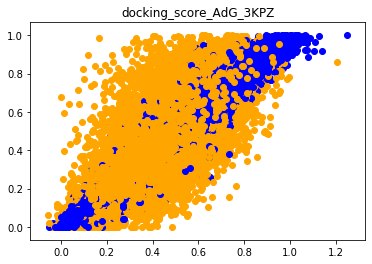

In [33]:
size = [2000, 5000, 10000, 14000]
epochs = 30

all_models = []
all_results = []


for name in names_ds:
    models = []
    results = []
    for i, s in  enumerate(size):

        start = timer()

        train_set = df.sample(n=s)
        remainder = df.drop(train_set.index)
        test_set = remainder.sample(n=1200)

        trainX = np.array([np.array(xi) for xi in train_set.SVD_x])
        testX = np.array([np.array(xi) for xi in test_set.SVD_x])

        trainY = np.array(train_set[name], dtype=np.float32).ravel()
        testY = np.array(test_set[name], dtype=np.float32).ravel()

       
        model = MLPRegressor(solver='adam',
                            activation='relu',
                            hidden_layer_sizes=(600, 400, 200, 50))
        
        model.fit(trainX, trainY)
        
        scores = cross_val_score(model, testX, testY, 
            scoring='neg_mean_squared_error', 
            cv=3)
        '''

        model = create_mlp(trainX.shape[1], regress=True)
        opt = Adam(lr=1e-3, decay=1e-3 / epochs)
        model.compile(loss="mse", optimizer=opt, metrics=['mse'])
        history = model.fit(trainX, trainY, validation_data=(testX, testY),
                epochs=epochs, batch_size=256, verbose=0)
        
         '''

       

        results.append(np.mean(scores))
        models.append(model)
        
        a = model.predict(trainX)
        b = np.array(trainY, dtype=np.float32)
        plt.scatter(a, b, color = 'blue')
        a = model.predict(testX)
        b = np.array(testY, dtype=np.float32) 
        plt.scatter(a, b, color = 'orange')
        plt.title(name)
        plt.savefig(path+name+'_'+str(s))

        end = timer()
       
        print('this cycle took: ', (end-start), 'trainset size: ', len(trainX))
        print('results: ', np.mean(scores))
        
    all_models.append(models)
    all_results.append(results)

In [34]:
with open(path+'DataSize_test_keras.models', 'wb') as f:
        pickle.dump(all_models, f)
        
with open(path+'DataSize_test_keras.results', 'wb') as f:
        pickle.dump(all_results, f)

In [42]:
res_df = pd.DataFrame(all_results, columns=size, index=names_ds)
res_df

,5000,7000,9000,11000,13000
docking_score_CHEMPLP_1DB1,-0.007309,-0.006860,-0.006756,-0.007445,-0.006448
docking_score_CHEMPLP_3KPZ,-0.016194,-0.019475,-0.019374,-0.019041,-0.018472
docking_score_london_1DB1,-0.013398,-0.012011,-0.012148,-0.011850,-0.012188
docking_score_london_3KPZ,-0.014768,-0.014447,-0.014327,-0.013911,-0.014147
docking_score_ASE_1DB1,-0.007682,-0.006481,-0.006917,-0.007149,-0.006095
docking_score_ASE_3KPZ,-0.007670,-0.006482,-0.006655,-0.007065,-0.006343
docking_score_AHB_1DB1,-0.017841,-0.018050,-0.018019,-0.017954,-0.016859
docking_score_AHB_3KPZ,-0.015476,-0.015097,-0.015348,-0.016713,-0.015111
docking_score_AdG_1DB1,-0.014755,-0.014480,-0.014937,-0.016773,-0.015890
docking_score_AdG_3KPZ,-0.018495,-0.017619,-0.020014,-0.020644,-0.018533


In [15]:
res_df = pd.DataFrame(all_results, columns=size, index=names_ds)
res_df

,1000,2000,3000,4000,5000
docking_score_CHEMPLP_1DB1,-0.007265,-0.006597,-0.006669,-0.007296,-0.006437
docking_score_CHEMPLP_3KPZ,-0.020583,-0.021874,-0.018214,-0.020880,-0.017564
docking_score_london_1DB1,-0.015441,-0.014000,-0.013162,-0.013398,-0.012331
docking_score_london_3KPZ,-0.014600,-0.013401,-0.013827,-0.014329,-0.013298
docking_score_ASE_1DB1,-0.008654,-0.006924,-0.007203,-0.007703,-0.006099
docking_score_ASE_3KPZ,-0.007276,-0.006652,-0.006300,-0.006716,-0.005832
docking_score_AHB_1DB1,-0.018661,-0.018013,-0.017592,-0.017920,-0.019643
docking_score_AHB_3KPZ,-0.018178,-0.016235,-0.015581,-0.016792,-0.014086
docking_score_AdG_1DB1,-0.015097,-0.014735,-0.015375,-0.014672,-0.015900
docking_score_AdG_3KPZ,-0.018536,-0.020274,-0.019293,-0.019334,-0.018259


# Grid search

In [17]:
from sklearn.model_selection import GridSearchCV

In [98]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = RandomizedSearchCV(MLPRegressor(max_iter=2000, early_stopping=True),
                   parameters,
                   n_jobs=-1,
                   cv=3,
                   scoring='neg_mean_absolute_error')

clf.fit(trainX, trainY)
print(clf.score(trainX, trainY))
print(clf.best_params_)

-0.04447875818535655
{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.05, 'activation': 'relu'}


In [33]:
clf.cv_results_

{'mean_fit_time': array([ 51.70892053, 107.66049433, 112.53865037, 103.80421314]),
 'std_fit_time': array([ 6.59415245,  9.63347436,  8.09972394, 13.85028554]),
 'mean_score_time': array([0.12307119, 0.18510599, 0.17233968, 0.13025079]),
 'std_score_time': array([0.01695503, 0.03246388, 0.03469237, 0.01732644]),
 'param_hidden_layer_sizes': masked_array(data=[200, 300, 400, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': 200},
  {'hidden_layer_sizes': 300},
  {'hidden_layer_sizes': 400},
  {'hidden_layer_sizes': 500}],
 'split0_test_score': array([-0.06545267, -0.06775982, -0.060617  , -0.0642123 ]),
 'split1_test_score': array([-0.06064402, -0.0644547 , -0.06758335, -0.06271449]),
 'split2_test_score': array([-0.06211805, -0.06372833, -0.0695518 , -0.0647973 ]),
 'split3_test_score': array([-0.06485022, -0.05959163, -0.06602156, -0.06329852]),
 'split4_test_score': array([-0.06611777, -0.0598

In [99]:
reg1 = MLPRegressor(max_iter=2000, hidden_layer_sizes=(1000,800,600, 400, 200, 100),
                    learning_rate='adaptive',
                    alpha= 0.05,
                    early_stopping=True,
                    solver='adam')
reg1.fit(trainX, trainY)

MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(1000, 800, 600, 400, 200, 100),
             learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
             max_iter=2000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
             verbose=False, warm_start=False)

In [17]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import argparse
import locale
import time
import os

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)
KTF.set_session(session)


def create_mlp(dim, regress=False):
    
    model = Sequential()
    model.add(Dense(600, input_dim=dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))


    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return the model
    return model



In [ ]:
reg = create_mlp(600, regress=True)

0.01079378752221176 0.06060946366327714


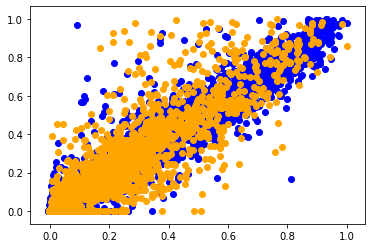

In [100]:
reg=reg1
a = reg.predict(trainX)
b = np.array(trainY, dtype=np.float32)
#print(np.count_nonzero(~np.isnan(a)), a[:10])
plt.scatter(a, b, color = 'blue')
a = reg.predict(testX)
b = np.array(testY, dtype=np.float32) 
#print(np.count_nonzero(~np.isnan(a)), a[:10])
plt.scatter(a, b, color = 'orange')
print(mean_squared_error(a, b), mean_absolute_error(a, b))

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern

kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
reg1 = GaussianProcessRegressor(kernel=kernel)
reg1.fit(trainX, trainY)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [25]:
from sklearn.linear_model import BayesianRidge
\from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,ExtraTreesRegressor

In [60]:
#reg = KNeighborsRegressor(n_neighbors=2)
'''
reg =GradientBoostingRegressor(learning_rate=.05,max_depth=4,n_estimators=210, 
                              min_samples_leaf=1,
                              min_samples_split=2)
'''
#reg = ExtraTreesRegressor(n_estimators=300)
reg = AdaBoostRegressor()
#reg = RadiusNeighborsRegressor(radius=0.5)
reg.fit(trainX, trainY)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                         metric_params=None, n_jobs=None, p=2, radius=1.1,
                         weights='uniform')

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': np.arange(50,350,50),
                                  'max_depth': np.arange(8,20,2)}

rs = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                                    param_distributions = param_dist,
                                    cv=3,
                                    n_iter = 10,
                                    scoring='neg_mean_absolute_error', n_jobs=-1)

rs.fit(trainX, trainY)
print(rs.best_score_)
print(rs.best_params_)

-0.09189781142352971
{'n_estimators': 300, 'max_depth': 18}


In [94]:

reg = RadiusNeighborsRegressor(radius=4.5)
reg.fit(trainX, trainY)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                         metric_params=None, n_jobs=None, p=2, radius=4.5,
                         weights='uniform')

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neighbors\_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

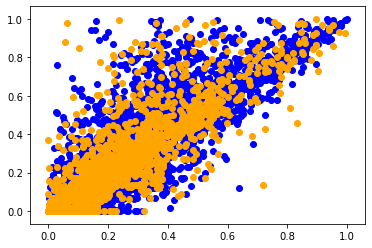

In [95]:
#reg=reg1
a = reg.predict(trainX)
b = np.array(trainY, dtype=np.float32)
#print(np.count_nonzero(~np.isnan(a)), a[:10])
plt.scatter(a, b, color = 'blue')
a = reg.predict(testX)
b = np.array(testY, dtype=np.float32) 
#print(np.count_nonzero(~np.isnan(a)), a[:10])
plt.scatter(a, b, color = 'orange')
print(mean_squared_error(a, b), mean_absolute_error(a, b))

In [20]:
param_grid_gbr={'learning_rate':[.1,.05],'max_depth':[4,5], 
                'n_estimators':range(120,241,30)}
gridsearch_gbr=\
GridSearchCV(GradientBoostingRegressor(),param_grid_gbr,n_jobs=5)\
.fit(X_train,y_train)
gridsearch_gbr.best_params_

NameError: name 'GradientBoostingRegressor' is not defined

# BO of hyperparameters

In [16]:
#https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/hyperparameter-optimization.py

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Integer(2, 100, name='min_samples_split')]
          #Integer(1, 100, name='min_samples_leaf')]

model = GradientBoostingRegressor(n_estimators=50, random_state=0)
# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, trainX, trainY, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been eval

'Best score=0.0588'

In [64]:
model = RandomForestRegressor(criterion='entropy', max_features=2, random_state=1)

# define the space of hyperparameters to search
search_space = [Integer(10, 500, name='n_estimators'), Integer(5, 25, name='max_depth')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):

    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, trainX, trainY, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    # calculate the mean of the scores
    estimate = mean(result)
    return estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [27]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [28]:
from sklearn.ensemble import RandomForestRegressor
repre = 'SVD_mfp_MLPr_'
#metrics_vec = []
#metrics_val_vec = []
MLP_regressors = []




for index, k in enumerate(names_ds):
    
    # Y data  
    
    trainY = np.array(train_set[k], dtype=np.float32).ravel()
    #trainY = np.array(train_set[k], dtype=np.float32).reshape(-1,1)
    #trainY = min_max_scaler.fit_transform(trainY).ravel()
    #y = sc.fit_transform(y)
    name = 'ds_' + k

    regressor = MLPRegressor(hidden_layer_sizes = (600, 200, 100, 50), random_state = 1, 
                             activation='relu', solver='adam')
    #regressor = RandomForestRegressor(max_depth=10, random_state=1, n_estimators=500)
    regressor.fit(trainX, trainY)
    MLP_regressors.append(regressor)
    #print(regressor.loss_)

    #utils.all_metrics(regressor, testX, testY, metrics_val_vec)    
    #utils.show_corr(regressor, trainX, trainY, testX, testY, path, name, repre,False)

    
#df2save = pd.DataFrame(metrics_val_vec, columns = ['mae', 'mse', 'mape'])
#df2save['ds_names'] = names
#df2save.to_csv(path+repre+'regress01.csv')
with open(path+'MLP_regressors_02.model', 'wb') as f:
        pickle.dump(MLP_regressors, f)


C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_netwo

In [15]:
# Fill the tables with predicted data

In [31]:
list_pred_1P8D_dfs = []
list_pred_1PQ6_dfs = []

# change input data for train_set, test_set or df
table = df
#table = train_set
testX = np.array([np.array(xi) for xi in table.SVD_x])
# list of ids for Isabels function
#sorted_ids_ref=sorted(list_pred_1PQ6_dfs[0].id.tolist())



for index, name in enumerate(names_ds):
    testY = np.array(table[name], dtype=np.float32)  
    
    pred_data = MLP_regressors[index].predict(testX)
    col_name = 'pred_'+name
    
    if index%2==0:   
        test_df = table[['id', 'smi', 'ECR_1DB1']].copy()
        test_df[col_name] = pred_data
        test_df[name] = testY
        list_pred_1P8D_dfs.append(test_df.sort_values(by=[col_name]).reset_index(drop=True))
    else:
        test_df = table[['id', 'smi', 'ECR_3KPZ']].copy()
        test_df[col_name] = pred_data
        test_df[name] = testY
        list_pred_1PQ6_dfs.append(test_df.sort_values(by=[col_name]).reset_index(drop=True))
 

In [26]:
table = train_set

names_1PQ6 = ['docking_score_CHEMPLP_1PQ6',
                'docking_score_LondondG_1PQ6',
                'docking_score_ASE_1PQ6',
                'docking_score_AdG_1PQ6',
                'docking_score_AHB_1PQ6']
df_1PQ6_dfs = []
for name in names_1PQ6:
    ole = table[['id', name]].copy()
    df_1PQ6_dfs.append(ole.sort_values(by=[name]).reset_index(drop=True))
    
names_1P8D = ['docking_score_CHEMPLP_1P8D',
                'docking_score_LondondG_1P8D',
                'docking_score_ASE_1P8D',
                'docking_score_AdG_1P8D',
                'docking_score_AHB_1P8D']
df_1P8D_dfs = []
for name in names_1P8D:
    ole = table[['id', name]].copy()
    df_1P8D_dfs.append(ole.sort_values(by=[name]).reset_index(drop=True))  



KeyError: "['docking_score_CHEMPLP_1PQ6'] not in index"

In [123]:
# CALCULATE ECR
ecr_pred_1PQ6 = ECR(list_pred_1PQ6_dfs)
ecr_pred_1P8D = ECR(list_pred_1P8D_dfs)
ecr_1PQ6 = ECR(df_1PQ6_dfs)
ecr_1P8D = ECR(df_1P8D_dfs)

In [202]:
# test if the ECR function is ok
'''
df_ori= df_ori.sort_values(by=['id'])
sorted_ids = df_ori.id
ecr = ECR(df_1PQ6_dfs, sorted_ids)
'''

"\ndf_ori= df_ori.sort_values(by=['id'])\nsorted_ids = df_ori.id\necr = ECR(df_1PQ6_dfs, sorted_ids)\n"

In [213]:
len(ecr_gen_1P8D),len(ecr_1P8D)

(1000, 8390)

0.5468445835864838 0.5359540606785069
0.5077237130380476 0.5333410233838763


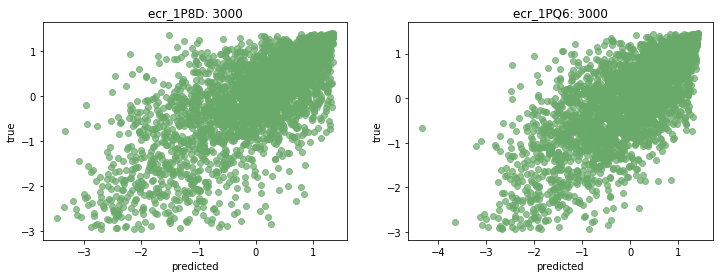

In [228]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

fig, axs = plt.subplots(1, 2, figsize=(12,4))
i = 1
x = 1
data_a =  [ecr_gen_1P8D, ecr_gen_1PQ6]
data_b = [ecr_1P8D, ecr_1PQ6]
title_names = ['ecr_1P8D: 3000', 'ecr_1PQ6: 3000']

for y in range(len(data_a)):
    a = scaler.fit_transform(np.log(data_a[y]).reshape(-1, 1))
    b = scaler.fit_transform(np.log(data_b[y]).reshape(-1, 1))
    axs[y].scatter(a, b, color = '#69A969',alpha=0.7)
    axs[y].set(xlabel='predicted', ylabel='true')
    axs[y].set_title(title_names[y])
    print(mean_squared_error(a, b), mean_absolute_error(a, b))

In [296]:
#generate data with given MAE
from random import gauss, uniform
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
gen_mse_mae = []

In [309]:
table = df.sample(3000)
for c in np.arange(1,11, 0.5):

    list_gen_1P8D_dfs = []
    list_gen_1PQ6_dfs = []

    stats = []
    for name in names_1PQ6:
        new_col = []
        gen_1PQ6_dfs = table[['id']].copy()
        data_col = table[name]
        MAE = (np.std(data_col))/c
        for number in data_col:
            new_col.append(gauss(number, MAE))

        gen_1PQ6_dfs[name] = new_col
        list_gen_1PQ6_dfs.append(gen_1PQ6_dfs.sort_values(by=[name]).reset_index(drop=True))

    for name in names_1P8D:
        new_col = []
        gen_1P8D_dfs = table[['id']].copy()
        data_col = table[name]
        MAE = (np.std(data_col))/c
        for number in data_col:
            new_col.append(gauss(number, MAE))

        gen_1P8D_dfs[name] = new_col
        list_gen_1P8D_dfs.append(gen_1P8D_dfs.sort_values(by=[name]).reset_index(drop=True))

    df_1PQ6_dfs = []
    for name in names_1PQ6:
        ole = table[['id', name]].copy()
        df_1PQ6_dfs.append(ole.sort_values(by=[name]).reset_index(drop=True))

    df_1P8D_dfs = []
    for name in names_1P8D:
        ole = table[['id', name]].copy()
        df_1P8D_dfs.append(ole.sort_values(by=[name]).reset_index(drop=True))  

    # CALCULATE ECR
    ecr_gen_1PQ6 = ECR(list_gen_1PQ6_dfs)
    ecr_gen_1P8D = ECR(list_gen_1P8D_dfs)
    ecr_1PQ6 = ECR(df_1PQ6_dfs)
    ecr_1P8D = ECR(df_1P8D_dfs)

    #fig, axs = plt.subplots(1, 2, figsize=(12,4))
    i = 1
    x = 1
    data_a =  [ecr_gen_1P8D, ecr_gen_1PQ6]
    data_b = [ecr_1P8D, ecr_1PQ6]
    title_names = ['ecr_1P8D: 3000', 'ecr_1PQ6: 3000']

    for y in range(len(data_a)):
        a = scaler.fit_transform(np.log(data_a[y]).reshape(-1, 1))
        b = scaler.fit_transform(np.log(data_b[y]).reshape(-1, 1))
        #axs[y].scatter(a, b, color = '#69A969',alpha=0.7)
        #axs[y].set(xlabel='predicted', ylabel='true')
        #axs[y].set_title(title_names[y])
        print(mean_squared_error(a, b), mean_absolute_error(a, b))
        gen_mse_mae.append([mean_squared_error(a, b), mean_absolute_error(a, b)])

1.3750868791201778 0.8806997981897045
1.5235169573062213 0.9476991027684013
1.149766538085751 0.8049240074264083
1.3423563626771016 0.8869804760196406
1.029497706579417 0.7489167127202686
0.9911192201619905 0.7561762865197628
0.8563823889396658 0.68508584046697
0.8682389893322839 0.7061194347600473
0.7083803308015681 0.61466639003328
0.6799640086170211 0.6167622834519447
0.6319275759110239 0.5745294571039138
0.5821471205673228 0.5771238977145945
0.5190576658170801 0.5151053326411292
0.490845049877171 0.5235899066503186
0.48774527649705623 0.49224440694475274
0.43322127627108586 0.48671696378307455
0.42686487404080814 0.45642682252800465
0.3570251231360485 0.44372945891488835
0.37906533689910415 0.43476581482494636
0.32040936715439317 0.4181737385037857
0.3548057980227506 0.4172642587877572
0.27736084355698043 0.38631837395615065
0.3161171267820194 0.3948099144231227
0.257521765515946 0.3724813463511861
0.2987546131933405 0.3782831112373934
0.23812264893431098 0.35520907696864795
0.2462

In [192]:
df_stats = pd.DataFrame(stats)
df_stats.mean(), df_stats.std()

(0    4.649545
 1    1.721891
 dtype: float64, 0    0.153010
 1    0.027913
 dtype: float64)

In [316]:
len(ole),len(np.arange(1,11,0.5))

(30, 20)

In [313]:
ole = [t for i, t in enumerate(gen_mse_mae) if i%2==0]

In [317]:
to_plot = pd.DataFrame(ole[10:], columns=['mse', 'mae'])
to_plot['no'] = np.arange(1,11,0.5)

Text(0.5, 0, 'coef')

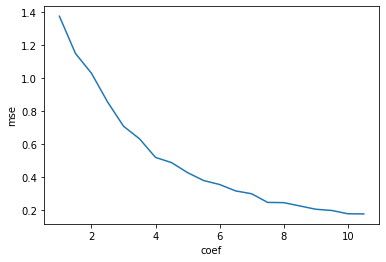

In [323]:
plt.plot(to_plot.no, to_plot['mae'])
plt.ylabel('mse')
plt.xlabel('coef')

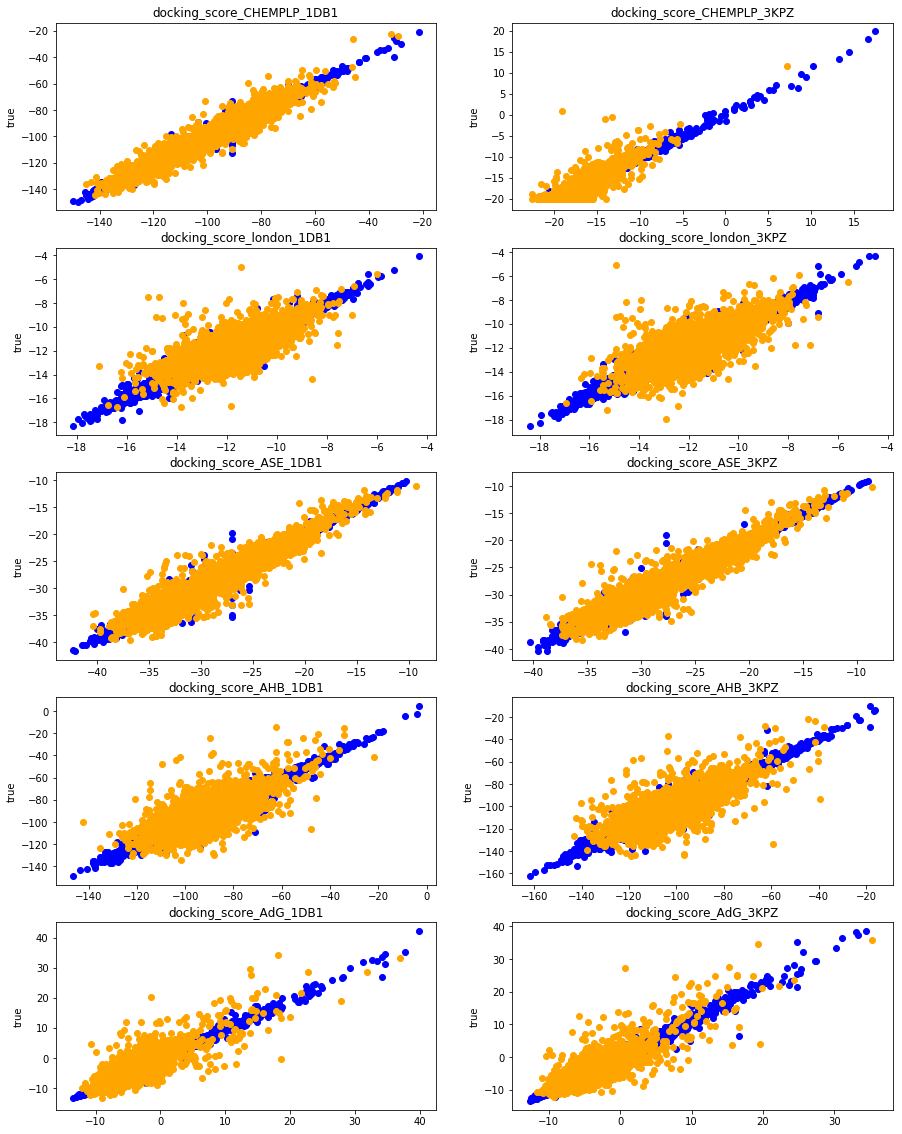

In [30]:
from matplotlib.pyplot import figure

testX = np.array([np.array(xi) for xi in test_set.SVD_x])
trainX = np.array([np.array(xi) for xi in train_set.SVD_x])
fig, axs = plt.subplots(5, 2, figsize=(15,20))
metrics = []

y = -1

for i, reg in enumerate(MLP_regressors):

    if i%2==0:
        x = 0
        y += 1
    else:
        x = 1
        
    a = reg.predict(trainX)
    b = np.array(train_set[names_ds[i]], dtype=np.float32)    
    axs[y, x].scatter(a, b, color = 'blue')
    
    a = reg.predict(testX)
    b = np.array(test_set[names_ds[i]], dtype=np.float32)    
    axs[y, x].scatter(a, b, color = 'orange')
    metrics.append([mean_squared_error(a, b), mean_absolute_error(a, b)])
    
    axs[y, x].set(xlabel='', ylabel='true')
    axs[y, x].set_title(names_ds[i])
    
fig.savefig(path+'VDR_all_data_regress_adam_relu_svd600_scaled.png')

In [51]:
df_metr = pd.DataFrame(metrics)
df_metr.to_csv(path+'relu_scaled_adam_df_metr.csv')

In [139]:
list_pred_1P8D_dfs[i]

,id,smi,ECR_1P8D,pred_docking_score_LondondG_1P8D,docking_score_LondondG_1P8D
0,LXRbML68055,FC(F)(F)C1=[C-]C=C(C)[C-]1c1cc(NCc2ccc(cc2)CC(...,3.678794e-02,-14.838085,-18.530052
1,LXRbML45479,O(CCCN(C(=O)C1(N(c2c(cc(cc2)CCC)CC1)C)C)C)C1=C...,1.652989e-02,-15.120087,-18.226820
2,LXRbML114607,Clc1c(cccc1CN(C(C)c1ccccc1)CCC)C(F)(F)COc1c2c(...,5.516564e-04,-14.202843,-17.639835
3,LXRbML105515,S(=O)(=O)(NCCOc1c(cc(cc1CCC)C(O)(C(F)(F)F)C(F)...,3.697864e-04,-13.707307,-17.603312
4,LXRbML209376,s1c(ccc1CN(S(=O)(=O)c1ccccc1C(F)(F)F)C(=O)c1cc...,2.478752e-04,-15.615206,-17.580000
...,...,...,...,...,...
2093,LXRbML195947,FC(CC)(C(=O)NC(=O)C(CCCN(Cc1cc(OCCCC(C)c2ccccc...,4.921550e-308,-9.665085,-7.173887
2094,LXRbML247487,Clc1c(cccc1C(F)(F)F)CN(CC(c1ccc2=c(ccc1)cc2)c1...,2.013493e-117,-7.603105,-7.099238
2095,LXRbML101440,ClCc1oc2cc(ccc2c1)CCN(Cc1ccccc1CC)CC(c1cc(ccc1...,9.487123e-59,-9.761454,-6.984233
2096,LXRbML19679,Clc1c(cccc1C(F)(F)F)CN(CC(c1cc(ccc1)C)c1ccccc1...,3.535522e-64,-7.426296,-6.954044


In [172]:
df_ecr = pd.DataFrame(ecr)
df_ecr.to_csv(path+'ecr_1PQ6_all.csv')

In [126]:
def ECR(list_dfs):
    '''
    FUNCTION:
    Computes the ECR value for 5 different docking scores. With the id and the rank for a particular conformation
    and the list of all the conformations, you compute the ECR.
    INPUTS:
    list_dfs = list of dataframes of docking scores sorted from better (more negative) to worst docking score.
    The only thing you need is the id_conf (id of the conformation) and the rank (I use the index of dataframes
    but you have the rank number on the sdf files as well)
    sorted_ids_ref = list of strings (id_conf)
    OUTPUTS:
    list_ranks = list of floats (ECR scores)
    '''
    sorted_ids_ref = list_dfs[0].sort_values(by='id').id 
    list_ranks=[]
    for x in sorted_ids_ref:
       rank1 = float(list_dfs[0].loc[list_dfs[0]["id"]==x].index.values.tolist()[0])/10
       rank2 = float(list_dfs[1].loc[list_dfs[1]["id"]==x].index.values.tolist()[0])/10
       rank3 = float(list_dfs[2].loc[list_dfs[2]["id"]==x].index.values.tolist()[0])/10
       rank4 = float(list_dfs[3].loc[list_dfs[3]["id"]==x].index.values.tolist()[0])/10
       rank5 = float(list_dfs[4].loc[list_dfs[4]["id"]==x].index.values.tolist()[0])/10
       ECR_n = np.exp(-rank1)/10+np.exp(-rank2)/10+np.exp(-rank3)/10+np.exp(-rank4)/10+np.exp(-rank5)/10
       list_ranks.append(ECR_n)
    return list_ranks

# CATEGORIES

In [12]:
path = 'f:/_phd/Docking_score/LXrb/Data/models/'

In [241]:
repre = 'SVD_mfp_MLPr_all_'
pred_y = []
metrics_val_vec = []
rgrs = []
index = 0
categories = range(1,4)

#trainX = np.array([np.array(xi) for xi in train_set.SVD_x])

    
for index, ds in enumerate(names):
    models = []
          
    cats = pd.qcut(train_set[names[index]], len(categories), labels=categories)
    y = train_set[names[index]]
    name = ds

    df_sel = pd.DataFrame(zip(cats, y), columns=['cats', 'y'])
    df_sel['x'] = train_set.SVD_x.tolist()

    for cat in categories:

        trainY = df_sel[df_sel.cats==cat].y
        x_sel = df_sel[df_sel.cats==cat].x
        trainX = np.array([np.array(xi) for xi in x_sel])

        regressor = MLPRegressor(hidden_layer_sizes = (500, 400, 300, 200), random_state = 1)
        regressor.fit(trainX, trainY)
        models.append(regressor)


       # utils.show_corr(regressor, trainX, trainY, testX, testY, path, name, repre,False)


    metrics_val_vec.append(utils.all_metrics_from_models(models, x_s, true_y)[0])
    pred_y.append(utils.all_metrics_from_models(models, x_s, true_y)[1])

    rgrs.append(models)

df2save = pd.DataFrame(metrics_val_vec, columns = ['mae', 'mse', 'mape'])
df2save['names'] = names
df2save.to_csv(path+repre+'regress_by_3_cat.csv')   
with open(path+'rgrs_all_3_cat.model', 'wb') as f:
        pickle.dump(rgrs, f)


8

In [ ]:
# Predict categories

In [243]:
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

classifiers = []
# predicted categories
pred_cat = []
test_data_x = []
test_data_true_y = []
#x = preprocessing.scale(transformed)
trainX = np.array([np.array(xi) for xi in train_set.SVD_x])
categories = range(1,4)

for index, k in enumerate(names):
    
    cats = pd.qcut(train_set[k], len(categories), labels=categories)
    y = cats
    trainY = np.array(y, dtype=np.float32)
    name = names[index]
       
    
    svm_classifier = OneVsRestClassifier(SVC(decision_function_shape='ovr'))
    #OneVsRestClassifier(SVC())
    #SVC(decision_function_shape='ovo')
    svm_classifier.fit(trainX, trainY)
   
    
    #pred_cat.append(svm_classifier.predict(testX))
    #test_data_x.append(testX)
    #test_data_true_y.append(testY)
    classifiers.append(svm_classifier)
    
    with open(path+'svc_'+'_3_cat.model', 'wb') as f:
        pickle.dump(classifiers, f) 

In [248]:
# What docking score is picked, list is saved in vairable 'names'
index = 1
len(classifiers)

10

In [249]:
from sklearn.metrics import confusion_matrix

y_pred_c = classifiers[index].predict(test_set.SVD_x)
y_true_c =test_set[names[index]]

print(y_pred_c[:10], y_true_c[:10])


cnf_matrix = confusion_matrix(y_true_c, y_pred_c,labels=categories)
np.set_printoptions(precision=2)
cnf_matrix

ValueError: setting an array element with a sequence.

In [20]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import plot as plt

disp = plot_confusion_matrix(classifiers[index], test_data_x[index], test_data_true_y[index],
                                                display_labels=categories,
                                                cmap=plt.cm.Blues,
                                                normalize='true')

disp.ax_.set_title(names[index])


AttributeError: 'function' object has no attribute 'cm'

In [19]:
# by predicted categories

In [254]:
len(b)

2227

In [257]:
repre = 'by_predicted_cats_'
index = 8
results = []
pred_by_pred_cat = []
x = np.array([np.array(xi) for xi in test_set.SVD_x])
for i in range(len(names)):
    preds = []

    y = classifiers[i].predict(x)
    
    df_pred_cat = pd.DataFrame(zip(y, x), columns=['y','x'])
    
    for cat in categories:

        x_sel = df_pred_cat[df_pred_cat.y==cat].x
        x_sel = np.array([np.array(xi) for xi in x_sel])

        pred = rgrs[i][cat-1].predict(x_sel)
        preds += pred.tolist()


    a = test_set[names[i]]
    b = preds
    results.append([mean_squared_error(a, b), mean_absolute_error(a, b)])
    pred_by_pred_cat.append(preds)
df_pred_res = pd.DataFrame(results, columns =(['mse', 'mae']))

In [259]:
df_pred_res

,mse,mae
0,549.583853,20.366055
1,1411.102969,32.108688
2,0.834231,0.695321
3,3.039973,1.368123
4,20.350247,3.716296
5,47.474016,5.956497
6,50.335769,5.378028
7,79.649844,7.047186
8,335.612774,14.553828
9,455.816985,16.912154


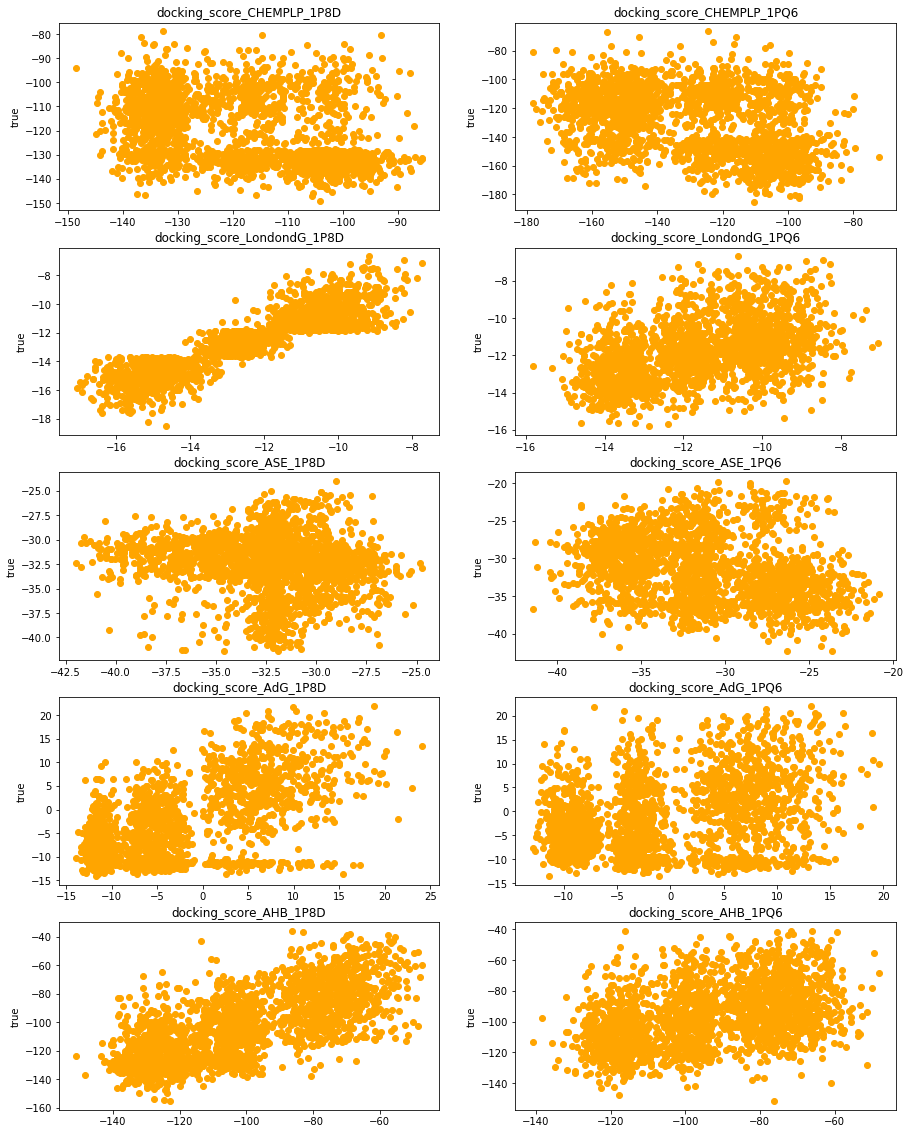

In [258]:
from matplotlib.pyplot import figure

fig, axs = plt.subplots(5, 2, figsize=(15,20))


y = -1

for i, name in enumerate(names):

    if i%2==0:
        x = 0
        y += 1
    else:
        x = 1
        
    #a = reg.predict(trainX)
    #b = np.array(train_set[names[i]], dtype=np.float32)    
    #axs[y, x].scatter(a, b, color = 'blue')
    
    a = pred_by_pred_cat[i]
    b = np.array(test_set[names[i]], dtype=np.float32)    
    axs[y, x].scatter(a, b, color = 'orange')
    
    axs[y, x].set(xlabel='', ylabel='true')
    axs[y, x].set_title(names[i])
    
fig.savefig(path+'LXRb_all_data_regress.png')

(108.114193705611, 7.760970118374163)

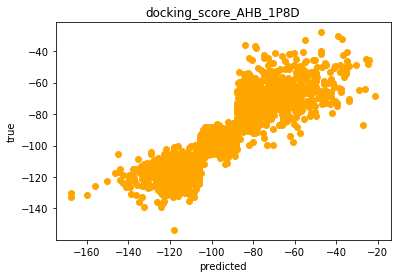

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.scatter(a, b, color = 'orange')   
plt.xlabel('predicted') 
plt.ylabel('true')
plt.title(names[index])
mean_squared_error(a, b), mean_absolute_error(a, b)

In [27]:
df_pred_res

,mse,mae
0,29.653900,3.954187
1,89.942823,5.014066
2,0.971359,0.736981
3,0.906069,0.698174
4,1.309121,0.885513
5,2.041940,1.116764
6,12.486663,2.307110
7,12.801669,2.419184
8,100.396043,7.591228
9,108.114194,7.760970


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

AttributeError: 'function' object has no attribute 'cm'

In [11]:
# CATEGORIES

In [12]:
y = pd.qcut(df[names[9]], 3, labels=[1, 2, 3])

In [38]:
y = pd.qcut(df[names[9]], 3, labels=[1, 2, 3])
from sklearn.neural_network import MLPClassifier
(trainX, testX, trainY, testY) = train_test_split(np.array([np.array(xi) for xi in x]), 
                                                          np.array(y),
                                                          stratify=df.label,
                                                          test_size=0.2, random_state=1)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(500,3), random_state=1, max_iter=200)
clf.fit(trainX, trainY)

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [66]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[1 1 0 ... 2 2 2]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


              precision    recall  f1-score   support

           1       0.55      0.63      0.59       312
           2       0.44      0.39      0.42       304
           3       0.56      0.53      0.55       288

    accuracy                           0.52       904
   macro avg       0.52      0.52      0.52       904
weighted avg       0.52      0.52      0.52       904

              precision    recall  f1-score   support

           1       0.56      0.64      0.60       290
           2       0.44      0.43      0.44       321
           3       0.60      0.54      0.57       293

    accuracy                           0.53       904
   macro avg       0.54      0.54      0.54       904
weighted avg       0.53      0.53      0.53       904

              precision    recall  f1-score   support

           1       0.52      0.56      0.54       296
           2       0.47      0.41      0.44       312
           3       0.57      0.60      0.59       296

    accuracy        

ValueError: Bin edges must be unique: array([2, 3, 3, 3], dtype=int64).
You can drop duplicate edges by setting the 'duplicates' kwarg

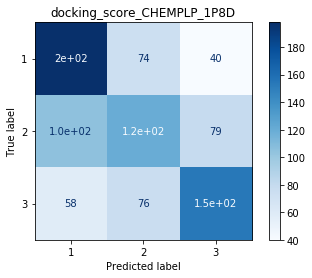

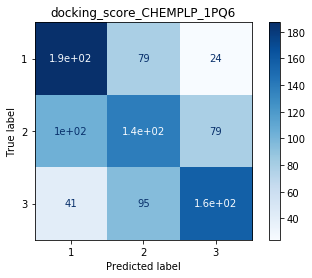

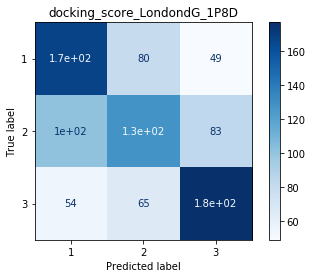

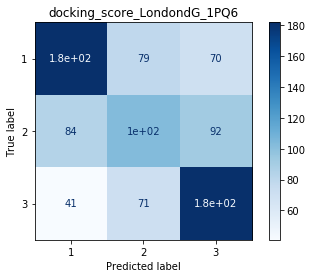

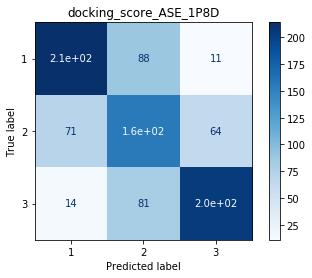

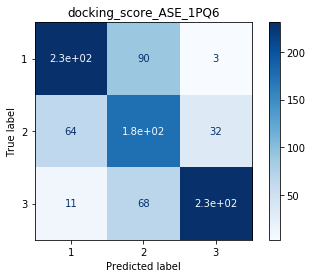

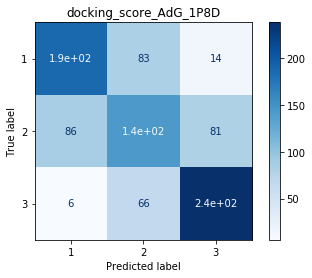

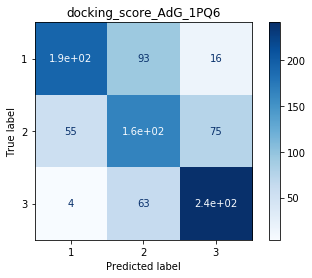

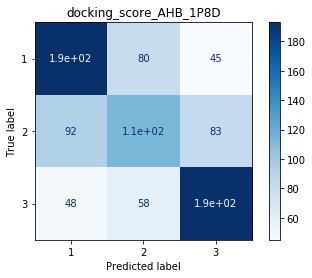

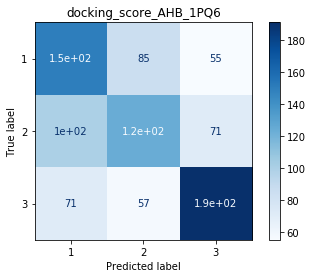

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

report_acc = []

for i in range(1,len(names)):
    # create categories with the same number of samples
    y = pd.qcut(df[names[i]], 3, labels=[1, 2, 3])
    name = names[i]

    # SVC Clasiffier
    (trainX, testX, trainY, testY) = train_test_split(np.array([np.array(xi) for xi in x]), 
                                                              y,
                                                              stratify=df.label,
                                                              test_size=0.2, random_state=1)
    svm_classifier = SVC(decision_function_shape='ovo')
    svm_classifier.fit(trainX, trainY)


    model = svm_classifier

    cm = plot_confusion_matrix(model, testX, testY,
                                     display_labels=[1,2,3],
                                     cmap=plt.cm.Blues)
    cm.ax_.set_title(name)    
    cm.figure_.savefig(fname=path+'cm_SVC_ovo'+name+'.png')

    predictions = model.predict(testX)
    tracc = ("Train Accuracy:" + name, accuracy_score(trainY, model.predict(trainX)), '\n')
    teacc =  ("Test Accuracy:" + name, accuracy_score(testY, model.predict(testX)), '\n')
    report_acc.append(tracc)
    report_acc.append(teacc)
    print(classification_report(testY, predictions))

In [25]:
report_acc

[('Train Accuracy:docking_score_CHEMPLP_1P8D', 0.7183955739972337, '\n'),
 ('Test Accuracy:docking_score_CHEMPLP_1P8D', 0.5221238938053098, '\n'),
 ('Train Accuracy:docking_score_CHEMPLP_1PQ6', 0.7391424619640388, '\n'),
 ('Test Accuracy:docking_score_CHEMPLP_1PQ6', 0.5331858407079646, '\n'),
 ('Train Accuracy:docking_score_LondondG_1P8D', 0.7125864453665284, '\n'),
 ('Test Accuracy:docking_score_LondondG_1P8D', 0.5221238938053098, '\n'),
 ('Train Accuracy:docking_score_LondondG_1PQ6', 0.7120331950207469, '\n'),
 ('Test Accuracy:docking_score_LondondG_1PQ6', 0.5165929203539823, '\n'),
 ('Train Accuracy:docking_score_ASE_1P8D', 0.7944674965421853, '\n'),
 ('Test Accuracy:docking_score_ASE_1P8D', 0.6360619469026548, '\n'),
 ('Train Accuracy:docking_score_ASE_1PQ6', 0.8074688796680498, '\n'),
 ('Test Accuracy:docking_score_ASE_1PQ6', 0.7035398230088495, '\n'),
 ('Train Accuracy:docking_score_AdG_1P8D', 0.7687413554633472, '\n'),
 ('Test Accuracy:docking_score_AdG_1P8D', 0.6283185840707964

In [27]:
report_acc

[('Train Accuracy:docking_score_CHEMPLP_1P8D', 0.7183955739972337, '\n'),
 ('Test Accuracy:docking_score_CHEMPLP_1P8D', 0.5221238938053098, '\n'),
 ('Train Accuracy:docking_score_CHEMPLP_1PQ6', 0.7391424619640388, '\n'),
 ('Test Accuracy:docking_score_CHEMPLP_1PQ6', 0.5331858407079646, '\n'),
 ('Train Accuracy:docking_score_LondondG_1P8D', 0.7125864453665284, '\n'),
 ('Test Accuracy:docking_score_LondondG_1P8D', 0.5221238938053098, '\n'),
 ('Train Accuracy:docking_score_LondondG_1PQ6', 0.7120331950207469, '\n'),
 ('Test Accuracy:docking_score_LondondG_1PQ6', 0.5165929203539823, '\n'),
 ('Train Accuracy:docking_score_ASE_1P8D', 0.7944674965421853, '\n'),
 ('Test Accuracy:docking_score_ASE_1P8D', 0.6360619469026548, '\n'),
 ('Train Accuracy:docking_score_ASE_1PQ6', 0.8074688796680498, '\n'),
 ('Test Accuracy:docking_score_ASE_1PQ6', 0.7035398230088495, '\n'),
 ('Train Accuracy:docking_score_AdG_1P8D', 0.7687413554633472, '\n'),
 ('Test Accuracy:docking_score_AdG_1P8D', 0.6283185840707964

# Regression by Categories 

((1507, 4455), (1507,))

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.029137704851424844


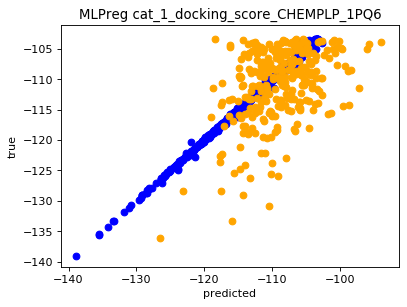

In [66]:
y = np.array(y, dtype=np.float32).reshape(-1,1)
#y = sc.fit_transform(y)
#y = column_or_1d(y, warn=True)
name = 'cat_1_' + names[i]

(trainX, testX, trainY, testY) = train_test_split(transformed,
                                                  y,
                                                  test_size=0.2, random_state=1)

regressor = MLPRegressor(hidden_layer_sizes = (500, 250, 100), random_state = 1)
regressor.fit(trainX, trainY)
print(regressor.loss_)
utils.show_corr(regressor, trainX, trainY, testX, testY, path, name, 'MLPreg ',False)

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.023442518759515682


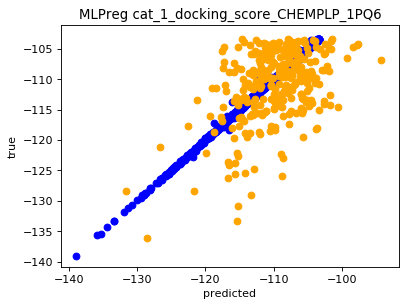

In [67]:
y = np.array(y, dtype=np.float32).reshape(-1,1)
#y = sc.fit_transform(y)
#y = column_or_1d(y, warn=True)
name = 'cat_1_' + names[i]

(trainX, testX, trainY, testY) = train_test_split(x_sel,
                                                  y,
                                                  test_size=0.2, random_state=1)

regressor = MLPRegressor(hidden_layer_sizes = (500, 250, 100), random_state = 1)
regressor.fit(trainX, trainY)
print(regressor.loss_)
utils.show_corr(regressor, trainX, trainY, testX, testY, path, name, 'MLPreg ',False)

In [148]:
index = 2
cat = 2

cats = pd.qcut(df[names[index]], 4, labels=[1, 2, 3, 4])
y = df[names[index]]

df_sel = pd.DataFrame(zip(cats, y), columns=['cats', 'y'])
df_sel['x'] = x.tolist()
y = df_sel[df_sel.cats==cat].y
x_sel = df_sel[df_sel.cats==cat].x
x_sel = np.array([np.array(xi) for xi in x_sel])

svd = TruncatedSVD(500) #90 % of variance covered by 500 components
transformed = svd.fit_transform(x_sel)
print(svd.explained_variance_ratio_.sum())

(trainX, testX, trainY, testY) = train_test_split(transformed,
                                                  y,
                                                  test_size=0.2, random_state=1)


0.9578967024328476


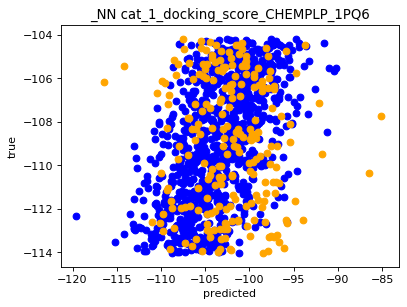

In [149]:
model = models.create_mlp(trainX.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / epochs)
model.compile(loss="mse", optimizer=opt, metrics=['mape', 'mae']) #mean_absolute_percentage_error
history = model.fit(trainX, trainY, validation_data=(testX, testY),
            epochs=epochs, batch_size=8, verbose=0)
utils.show_corr(model, trainX, trainY, testX, testY, path, name, '_NN ',False)

In [150]:
pred_cat_2 = model.predict(testX)

0.0010208829680735372


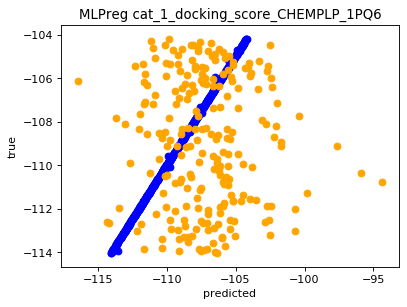

In [151]:
regressor = MLPRegressor(hidden_layer_sizes = (500, 400, 300, 200), random_state = 1)
regressor.fit(trainX, trainY)
print(regressor.loss_)
utils.show_corr(regressor, trainX, trainY, testX, testY, path, name, 'MLPreg ',False)

In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_1 = mean_absolute_error(testY, regressor.predict(testX))
mae_2 = mean_absolute_error(testY, model.predict(testX))

In [153]:
mae_1, mae_2

(3.854026705044261, 7.214644496141282)